### Generating Tabular Data Using Sequential FeatureForestFlow

This notebook comparison contains plots for the iris between data generation from the S3F approach and ForestFlow

### Imports

In [1]:
#Imports
from Seq3F.S3F import feature_forest_flow # Import from S3F 
from ForestFlow import ForestDiffusionModel
from sklearn.datasets import load_iris
import numpy as np
import copy
import xgboost as xgb
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import torch
# from torchcfm.conditional_flow_matching import ConditionalFlowMatcher

***In this notebook, we plot the generation result of [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), a classic tabular dataset about flowers with 150 observations, 4 input continuous variables (sepal length, sepal width, petal length, and petal width), and 1 categorical outcome variable (3 species of flowers; setosa, versicolor, and virginica).***

In [4]:
# Iris: numpy dataset with 4 variables (all numerical) and 1 outcome (categorical; 3 categories)
my_data = load_iris()
X, y = my_data['data'], my_data['target']

# shuffle the observations
new_perm = np.random.permutation(X.shape[0])
np.take(X, new_perm, axis=0, out=X)
np.take(y, new_perm, axis=0, out=y)

# Save data before adding missing values
X_true, y_true = copy.deepcopy(X), copy.deepcopy(y)
Xy_true = np.concatenate((X_true, np.expand_dims(y_true, axis=1)), axis=1)

In [5]:
X[0:10]

array([[7.7, 2.8, 6.7, 2. ],
       [7.2, 3.2, 6. , 1.8],
       [5.8, 4. , 1.2, 0.2],
       [6.4, 3.2, 5.3, 2.3],
       [4.6, 3.6, 1. , 0.2],
       [7.7, 3. , 6.1, 2.3],
       [5. , 3.2, 1.2, 0.2],
       [5.1, 3.4, 1.5, 0.2],
       [6.8, 3.2, 5.9, 2.3],
       [6.8, 2.8, 4.8, 1.4]])

In [6]:
y[0:10]

array([2, 2, 0, 2, 0, 2, 0, 0, 2, 1])

### Runge Kutta-Based Sequential Feature Forest Flow

In [7]:
HS3F_Rg4=feature_forest_flow(X, # Must be a Numpy dataset and
               label_y=y, # must be a categorical/binary variable
               cat_y=None, # Binary variable indicating whether or not the output is categorical
               n_t=50, # number of noise level
               model='xgboost', # xgboost, random_forest, lgbm, catboost,
               solver_type='Rg4', # solver type: argument (Euler or Rg4)
               model_type='HS3F',n_jobs=-1, # cpus used (feel free to limit it to something small, this will leave more cpus per model; for lgbm you have to use n_jobs=1, otherwise it will never finish)
               n_batch=0, # If >0 use the data iterator with the specified number of batches
               ngen=1, # The number generated batches, it will help us to limit the multinomial sampling in case the first variable of the data is categorical based on the class frequencies of this variable
               seed=0).generate(batch_size=None)

In [8]:
CS3F_Rg4=feature_forest_flow(X, # Must be a Numpy dataset and
               label_y=y, # must be a categorical/binary variable| When None then X shopuld be the entire data set
               cat_y=None, # Binary variable indicating whether or not the output is categorical
               n_t=50, # number of noise level
               model='xgboost', # xgboost, random_forest, lgbm, catboost,
               solver_type='Rg4', # solver type: argument (Euler or Rg4)
               model_type='CS3F',n_jobs=-1, # cpus used (feel free to limit it to something small, this will leave more cpus per model; for lgbm you have to use n_jobs=1, otherwise it will never finish)
               n_batch=0, # If >0 use the data iterator with the specified number of batches
               ngen=1, # The number generated batches, it will help us to limit the multinomial sampling in case the first variable of the data is categorical based on the class frequencies of this variable
               seed=0).generate(batch_size=None)

### Backward Euler-Based Sequential Feature Forest Flow

In [9]:
HS3F_Euler=feature_forest_flow(X, # Must be a Numpy dataset and
               label_y=y, # must be a categorical/binary variable| When None then X shopuld be the entire data set
               cat_y=True, # Binary variable indicating whether or not the output is categorical
               n_t=50, # number of noise level
               model='xgboost', # xgboost, random_forest, lgbm, catboost,
               solver_type='Euler', # solver type: argument (Euler or Rg4)
               model_type='HS3F',n_jobs=-1, # cpus used (feel free to limit it to something small, this will leave more cpus per model; for lgbm you have to use n_jobs=1, otherwise it will never finish)
               n_batch=0, # If >0 use the data iterator with the specified number of batches
               ngen=1, # The number generated batches, it will help us to limit the multinomial sampling in case the first variable of the data is categorical based on the class frequencies of this variable
               seed=0).generate(batch_size=None)

In [10]:
CS3F_Euler=feature_forest_flow(X, # Must be a Numpy dataset and
               label_y=y, # must be a categorical/binary variable| When None then X shopuld be the entire data set
               cat_y=True, # Binary variable indicating whether or not the output is categorical
               n_t=50, # number of noise level
               model='xgboost', # xgboost, random_forest, lgbm, catboost,
               solver_type='Euler', # solver type: argument (Euler or Rg4)
               model_type='CS3F',n_jobs=-1, # cpus used (feel free to limit it to something small, this will leave more cpus per model; for lgbm you have to use n_jobs=1, otherwise it will never finish)
               n_batch=0, # If >0 use the data iterator with the specified number of batches
               ngen=1, # The number generated batches, it will help us to limit the multinomial sampling in case the first variable of the data is categorical based on the class frequencies of this variable
               seed=0).generate(batch_size=None)

### ForestFlow

In [27]:
# %%time
forest_model = ForestDiffusionModel(X, label_y=y, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1, seed=1)
ForestFlow= forest_model.generate(batch_size=X.shape[0])


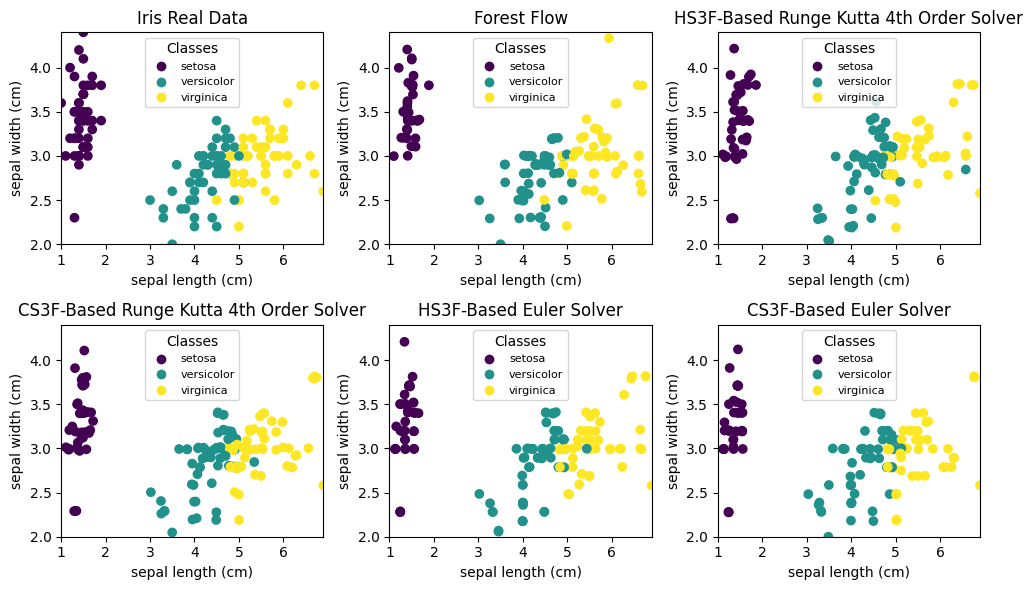

In [28]:
# Create subplots
def data_range(X):
  # Calculate the data range for x and y axes
  x_r= X[:, 2].min(), X[:, 2].max()
  y_r= X[:, 1].min(), X[:, 1].max()
  return x_r, y_r
x_r, y_r=data_range(Xy_true)
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
# print(len(axes))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()  # Flatten the 2D array of axes to a 1D array

# Real data
scatter = ax1.scatter(Xy_true[:, 2], Xy_true[:, 1], c=Xy_true[:, -1])
ax1.set_xlabel(my_data.feature_names[0])
ax1.set_ylabel(my_data.feature_names[1])
ax1.set_xlim(x_r)
ax1.set_ylim(y_r)
ax1.legend(scatter.legend_elements()[0], my_data.target_names, loc="upper center", title="Classes",prop={'size': 8})
ax1.set_title("Iris Real Data")

# Forest flow data
scatter = ax2.scatter(ForestFlow[:, 2],ForestFlow[:, 1], c=ForestFlow[:, -1])
ax2.set_xlabel(my_data.feature_names[0])
ax2.set_ylabel(my_data.feature_names[1])
ax2.set_xlim(x_r)
ax2.set_ylim(y_r)
ax2.legend(scatter.legend_elements()[0], my_data.target_names, loc="upper center", title="Classes",prop={'size': 8})
ax2.set_title("Forest Flow")

# HS3F-Based Rg4 data
scatter = ax3.scatter(HS3F_Rg4[:, 2], HS3F_Rg4[:, 1], c=HS3F_Rg4[:, -1])
ax3.set_xlabel(my_data.feature_names[0])
ax3.set_ylabel(my_data.feature_names[1])
ax3.set_xlim(x_r)
ax3.set_ylim(y_r)
ax3.legend(scatter.legend_elements()[0], my_data.target_names, loc="upper center", title="Classes",prop={'size': 8})
ax3.set_title("HS3F-Based Runge Kutta 4th Order Solver")

# CS3F-Based Rg4 data
scatter = ax4.scatter(CS3F_Rg4[:, 2], CS3F_Rg4[:, 1], c=CS3F_Rg4[:, -1])
ax4.set_xlabel(my_data.feature_names[0])
ax4.set_ylabel(my_data.feature_names[1])
ax4.set_xlim(x_r)
ax4.set_ylim(y_r)
ax4.legend(scatter.legend_elements()[0], my_data.target_names, loc="upper center", title="Classes",prop={'size': 8})
ax4.set_title("CS3F-Based Runge Kutta 4th Order Solver")

# HS3F-Based Euler data
scatter = ax5.scatter(HS3F_Euler[:, 2], HS3F_Euler[:, 1], c=HS3F_Euler[:, -1])
ax5.set_xlabel(my_data.feature_names[0])
ax5.set_ylabel(my_data.feature_names[1])
ax5.set_xlim(x_r)
ax5.set_ylim(y_r)
ax5.legend(scatter.legend_elements()[0], my_data.target_names, loc="upper center", title="Classes",prop={'size': 8})
ax5.set_title("HS3F-Based Euler Solver")

# CS3F-Based Euler  data
scatter = ax6.scatter(CS3F_Euler[:, 2], CS3F_Euler[:, 1], c=CS3F_Euler[:, -1])
ax6.set_xlabel(my_data.feature_names[0])
ax6.set_ylabel(my_data.feature_names[1])
ax6.set_xlim(x_r)
ax6.set_ylim(y_r)
ax6.legend(scatter.legend_elements()[0], my_data.target_names, loc="upper center", title="Classes",prop={'size': 8})
ax6.set_title("CS3F-Based Euler Solver")
# Adjust layout
plt.tight_layout()
plt.show()